
# Project 1: Digit Classification with KNN


# Intro
---
In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. 
As always, you're welcome to work on the project in groups and discuss ideas over Slack, but <b> please prepare your own write-up (with your own code). </b> To be safe, please credit any sources used.


## Grading
---
 - Make sure to answer every part in every question.
 - There are 5 questions, each worth an equal number of points.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean or is not well commented
   - the functions or answers are excessively long

## Requirements:
---
1. Comment your code.
1. Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning, keep things inside functions).

## Additional reading and notes
---

If you are looking to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

Additionally, if you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [58]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [59]:
import sklearn
sklearn.__version__

'1.0.2'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [60]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X.iloc[shuffle], Y.iloc[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]



data shape:  (70000, 784)
label shape: (70000,)


### Question 1: Visualize a select sample of images
---
Show a 10x10 grid that visualizes 10 examples of each digit.

Notes:
* Make the digits nice and big.
* You can use `plt.rc()` for setting the colormap, for example to black and white.
* You can use `plt.subplot()` for creating subplots.
* You can use `plt.imshow()` for rendering a matrix.
* You can use `np.array.reshape()` for reshaping a 1D feature vector into a 2D matrix (for rendering).

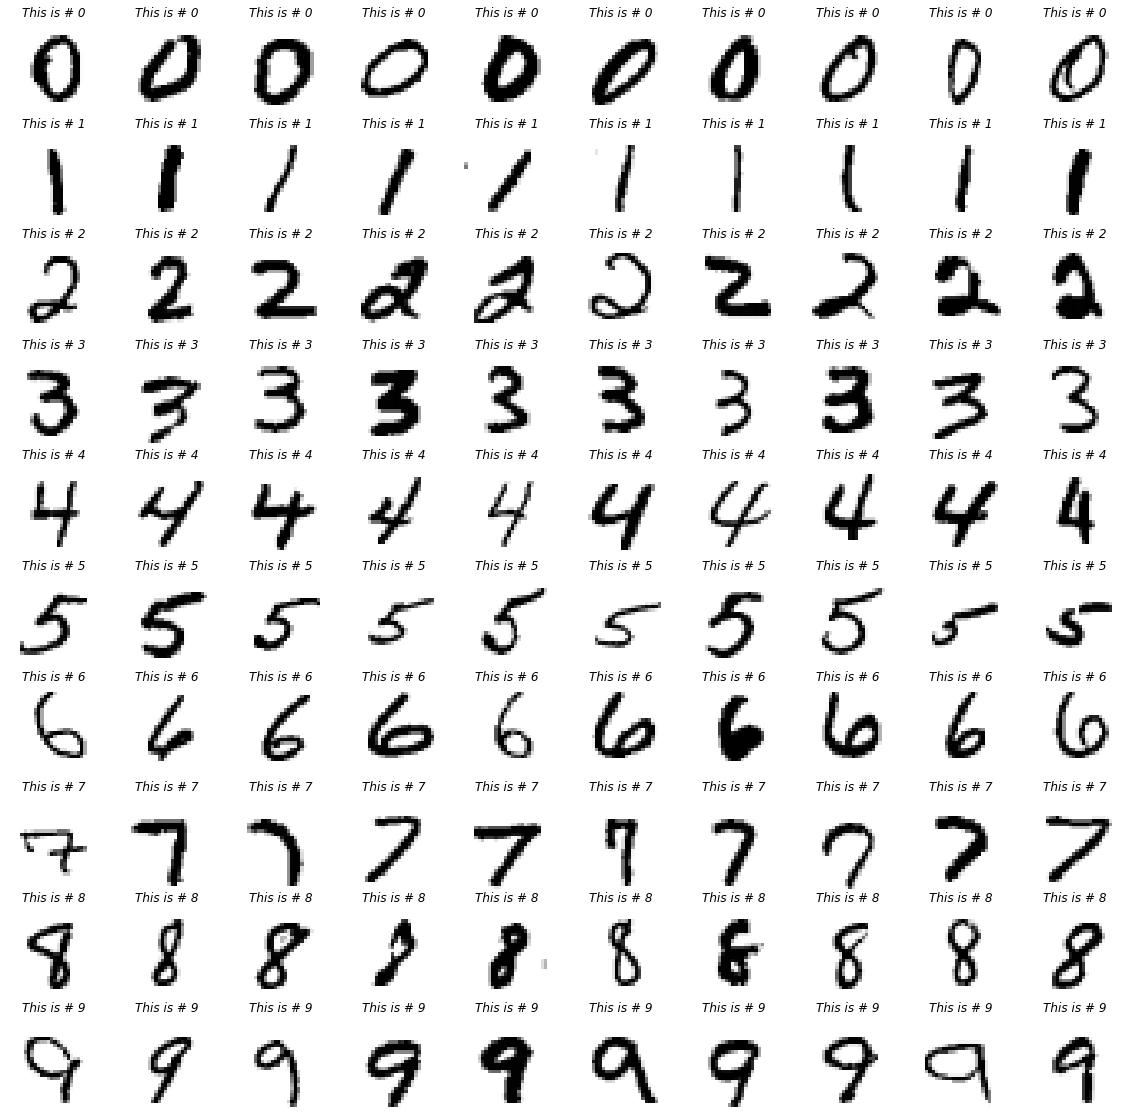

In [61]:
def Q1(num_examples=10):
  #Get all unique labels that are in the array
  digits = np.unique(Y)
  ex = num_examples

  #initialize & Create the Subplots to the appropriate table size + image size
  fig, axs = plt.subplots(len(digits), ex, figsize=(20,20))

  # Looping over every unique label in our dataset
  for un_dig in digits:
    c = 0

    #looping over labels in our dataset 
    for samp_digit in range(len(train_labels)):

      #checking to see if we have met the amount of examples needed for question
      if c <= ex - 1:

        #checking label to see if we have a match
        if int(un_dig) == int(train_labels.iloc[samp_digit]):

          #grabbing the raw pixel density data at the index of the row the label matched on, we then reshape the array to 2 dimensions
          #in order to appropriately plot points
          axs[int(un_dig)][int(c)].imshow(train_data.iloc[[samp_digit]].to_numpy().reshape(28,28), cmap=plt.cm.binary)

          #adding labels to each subplot
          axs[int(un_dig)][int(c)].set_title(f"This is # {un_dig}", fontstyle='italic')

          #turning axis off for better visualizations
          axs[int(un_dig)][int(c)].axis("off")
          c += 1
      else:
        
        #breaking out of first loop if we have already met the number of examples
        break
#parameter constraint of > 1
Q1(10)

### Question 2: Evaluating different choices of k
---

1. Produce k-Nearest Neighbors models with k = 1, 3, 5, 7, and 9.  
1. Print the accuracy of each model. 
1. Additionally, only for the 1-Nearest Neighbor model, show the precision, recall, and F1 for each label. 
1. Which digit is the most *difficult* for the 1-Nearest Neighbor model to classify correctly? How did you choose and why?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Print only the information asked so it is easy to read and compare.
* You can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* You can use `classification_report` to get precision, recall, and F1 results.
* Check out what the function "score" does.

In [62]:
def Q2(k_values):

  #Iterating over every K value that we are trying to create a model after
  for k in k_values:
    #creating an instance of the KNeighborsClassifier class with nearest neighbor set to the iterating iteger
    kNn_instance = KNeighborsClassifier(n_neighbors=int(k))

    #createing a model with respect to the mini_training data set with respect to the training labels
    kNn_instance.fit(mini_train_data, mini_train_labels)

    #Running development data through the model that was generated to predict parameters
    prediction_output = kNn_instance.predict(dev_data)

    #Running reporting on predicated classifications against the actual classifications and outputing it as a dictionary for ease of processing
    class_report = classification_report(dev_labels, prediction_output, output_dict=True)

    #Reporting on raw Accuracy value for each of the k nearest neighbor values
    accuracy_report = f"Accuracy for K:{str(k)} = {class_report.get('accuracy','N/A')}"
    print(accuracy_report)

    #Logical choice for k 1-nearest neighbor
    if int(k) == 1: 
      prt_str = f"K Neighbor Report for K={k}\n"

      #iterating over inner dictionary for the specific values that were requested
      for key,val in class_report.items():

        #Logical choice to again only choose label data that is 0-9 removing macro-avg and weighted-avg
        if key.isnumeric():
          prt_str += f"Label: {key}\tprecision: {val.get('precision', 'N/A')}\tRecall: {val.get('recall', 'N/A')}\tF1-Score: {val.get('f1-score', 'N/A')} \n"
      print(prt_str)

k_values = [1, 3, 5, 7, 9]
Q2(k_values)

Accuracy for K:1 = 0.884
K Neighbor Report for K=1
Label: 0	precision: 0.9528301886792453	Recall: 0.9528301886792453	F1-Score: 0.9528301886792453 
Label: 1	precision: 0.8854961832061069	Recall: 0.9830508474576272	F1-Score: 0.9317269076305221 
Label: 2	precision: 0.9032258064516129	Recall: 0.7924528301886793	F1-Score: 0.8442211055276382 
Label: 3	precision: 0.9333333333333333	Recall: 0.865979381443299	F1-Score: 0.8983957219251337 
Label: 4	precision: 0.9069767441860465	Recall: 0.8478260869565217	F1-Score: 0.8764044943820224 
Label: 5	precision: 0.8555555555555555	Recall: 0.875	F1-Score: 0.8651685393258427 
Label: 6	precision: 0.9215686274509803	Recall: 0.9215686274509803	F1-Score: 0.9215686274509803 
Label: 7	precision: 0.8495575221238938	Recall: 0.9411764705882353	F1-Score: 0.8930232558139535 
Label: 8	precision: 0.8275862068965517	Recall: 0.7659574468085106	F1-Score: 0.7955801104972374 
Label: 9	precision: 0.803921568627451	Recall: 0.8631578947368421	F1-Score: 0.83248730964467 

Accur

**Answer to part 4:**

The most difficult number for the model to predict is the number 2 because it has the lowest recall - the percentage of the total relative items classified by the algorithim - https://medium.com/@shrutisaxena0617/precision-vs-recall-386cf9f89488

### Question 3: Examining the importance of training size
---
1. Produce 1-Nearest Neighbor models using training data of various sizes. For example, ```train_data[:train_size]```.
1. Evaluate and show the accuracy achieved by each model.  
1. Show the time needed to: 
  1. Train each model.
  1. Measure the accuracy of each model.
1. What do you see? Is this what you expected to see and why?
1. Plot on the same graph (as a function of training size):
  1. the time needed for training
  1. the time needed for calculating accuracy

Notes:
* Evaluate on the dev set.
* You can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* You can use `time.time()` to measure elapsed time of operations.

{'train_size': 100, 'train_time': 0.008010149002075195, 'acc_time': 0.08292508125305176, 'accuracy': 0.702}
{'train_size': 200, 'train_time': 0.009348630905151367, 'acc_time': 0.0901038646697998, 'accuracy': 0.791}
{'train_size': 400, 'train_time': 0.009485960006713867, 'acc_time': 0.09685325622558594, 'accuracy': 0.811}
{'train_size': 800, 'train_time': 0.010390043258666992, 'acc_time': 0.12585687637329102, 'accuracy': 0.866}
{'train_size': 1600, 'train_time': 0.012882232666015625, 'acc_time': 0.17876577377319336, 'accuracy': 0.905}
{'train_size': 3200, 'train_time': 0.015055656433105469, 'acc_time': 0.23575258255004883, 'accuracy': 0.927}
{'train_size': 6400, 'train_time': 0.021535158157348633, 'acc_time': 0.42013025283813477, 'accuracy': 0.939}
{'train_size': 12800, 'train_time': 0.024743318557739258, 'acc_time': 0.6915144920349121, 'accuracy': 0.952}
{'train_size': 25600, 'train_time': 0.043419599533081055, 'acc_time': 1.2254338264465332, 'accuracy': 0.963}


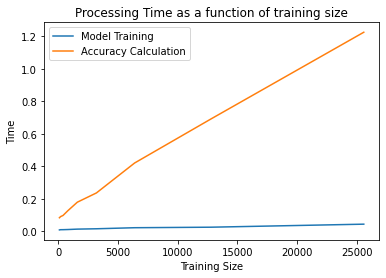

In [63]:
def Q3(train_sizes):
  # Constant for 1 Nearest Neighbor
  K_NEIGHBOR = 1

  # Collections used for storing and plotting runtime data
  train_size_evaluation = []
  train_times = []
  eval_times = []

  # Iterating over each one of the training sizes
  for size in train_sizes:
    # Getting start time in epoch time
    start_time = time.time()

    # Instantiating the KNeighborsClassifier class with the nearest neighbor constant of 1 
    kNn_instance = KNeighborsClassifier(n_neighbors=K_NEIGHBOR)

    # Training the model on the training dataset with various dataset sizes
    kNn_instance.fit(train_data[:size], train_labels[:size])

    # Getting end time in epoch for train time
    stop_train_time = time.time()

    # Starting prediction testing with the development dataset
    prediction_output = kNn_instance.predict(dev_data)

    # Generating a classification report with respect to the the development labels provided
    class_report = classification_report(dev_labels, prediction_output, output_dict=True)
    
    # Getting end time of in epoch for evaluation time
    stop_accuracy_time = time.time()

    # Storing data for presentation and future processing
    train_size_evaluation.append({"train_size" : size , 
                                  "train_time" : stop_train_time - start_time,
                                  "acc_time"   : stop_accuracy_time - start_time ,
                                  "accuracy"   : class_report.get('accuracy', 'N/A')
                                  })
  

  # Setting up graph structure & labeling
  plt.title('Processing Time as a function of training size')
  plt.xlabel('Training Size')
  plt.ylabel('Time')

  # Iterating over list of dictionaries for each one of the training dataset sizes
  for tS in train_size_evaluation:
    print(tS)
    train_times.append(tS.get("train_time"))
    eval_times.append(tS.get("acc_time"))

  # Plot training times & evaluation times as a function of training sizes (X Axis)
  plt.plot(train_sizes, train_times, label = "Model Training")
  plt.plot(train_sizes, eval_times, label = "Accuracy Calculation")
  plt.legend()

  plt.show()

  return train_size_evaluation
train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]

train_size_eval = Q3(train_sizes)

**Answer to Part 4**
I see that there is a direct correlation between training size and compute time for the model. This makes sense because the way KNN algorithim works is by taking the euclidian distance from every given point and finding which points have the shortest distance from eachother - classfying them based on that distance which in turn is allowing for label classification. 

### Question 4: Evaluating if we should obtain additional data
---

In this question we wish to predict what accuracy we would get if we had additional training data.

Our input, our features and labels, are the output from the previous question. Based on the training size and accuracy we got in the previous question, we wish to predict the accuracy we would get if we had larger training sizes.

1. Produce a linear regression model that predicts accuracy of a 1-Nearest Neighbor model given training set size. 
1. Print $R^2$ of the linear regression model.  
1. Print the accuracies predicted for training set sizes 60000, 120000, and 1000000.  
1. Plot on a lineplot graph:
  1. the actual accuracies we obtained in the previous question 
  1. and the accuracies our model predicted we would have gotten.
  1. The X axis is the training set size. 
  1. You can limit the range of X and Y to the range where you have data for both plots. Meaning, in the this question, we want to visualize how good the prediction is.
1. What are two things that are wrong with our model?
1. Apply a transformation to the predictor features and a transformation to the outcome that make the predictions fix these issues. 
1. Show $R^2$ of the improved linear regression model.  
1. Print the accuracies predicted for training set sizes 60000, 120000, and 1000000.  
1. Plot a lineplot graph of both again as before.
  1. Be sure to plot this where the Y axis is accuracy and X axis is training set size, **not the transformed space**!
  1. Choose the range of X and Y to visualize effectively.

Notes:
* Train the linear regression models on all of the (transformed) accuracies estimated in Problem 3.
* Evaluate the linear regression models on all of the (transformed) accuracies estimated in Problem 3.
* You can use `LinearRegression` to produce a linear regression model.
* Remember that the sklearn `fit()` functions take an input matrix X and output vector Y. So, each input example in X is a vector, even if it contains only a single value.
* Hints:
  1. You have two problems here, how well your model fits and predicting *illogical* values of accuracy.
  1. You can look at:
    1. [logit](https://en.wikipedia.org/wiki/Logit): $\frac{1}{1 + e^{-x}} = \frac{e^x}{1+e^x}$ which takes numbers in $\[\infty,-\infty\]$ and outputs numbers in $(0, 1)$.
    1. [logistic](https://en.wikipedia.org/wiki/Logistic_function): $log(\frac{p}{1 - p})$ which takes numbers between $(0, 1)$ and outputs numbers between $\[\infty,-\infty\]$.
    1. It also happens that $x = logistic(p)$ is the same thing as $logit(x)=p$.

P1: = [0.83558705 0.8362558  0.83759332 0.84026835 0.84561842 0.85631855
 0.87771881 0.92051933 1.00612037]

R2 of the linear Regression 1: 0.4177006634161019

Predctions for new training sizes [60000, 120000, 1000000] = [1.23617317 1.63742805 7.52249967]
R2 of the linear Regression 2: 0.9395242859897991

Improved Predctions for new training sizes [60000, 120000, 1000000] = [0.96307017 0.96659196 0.97413657]



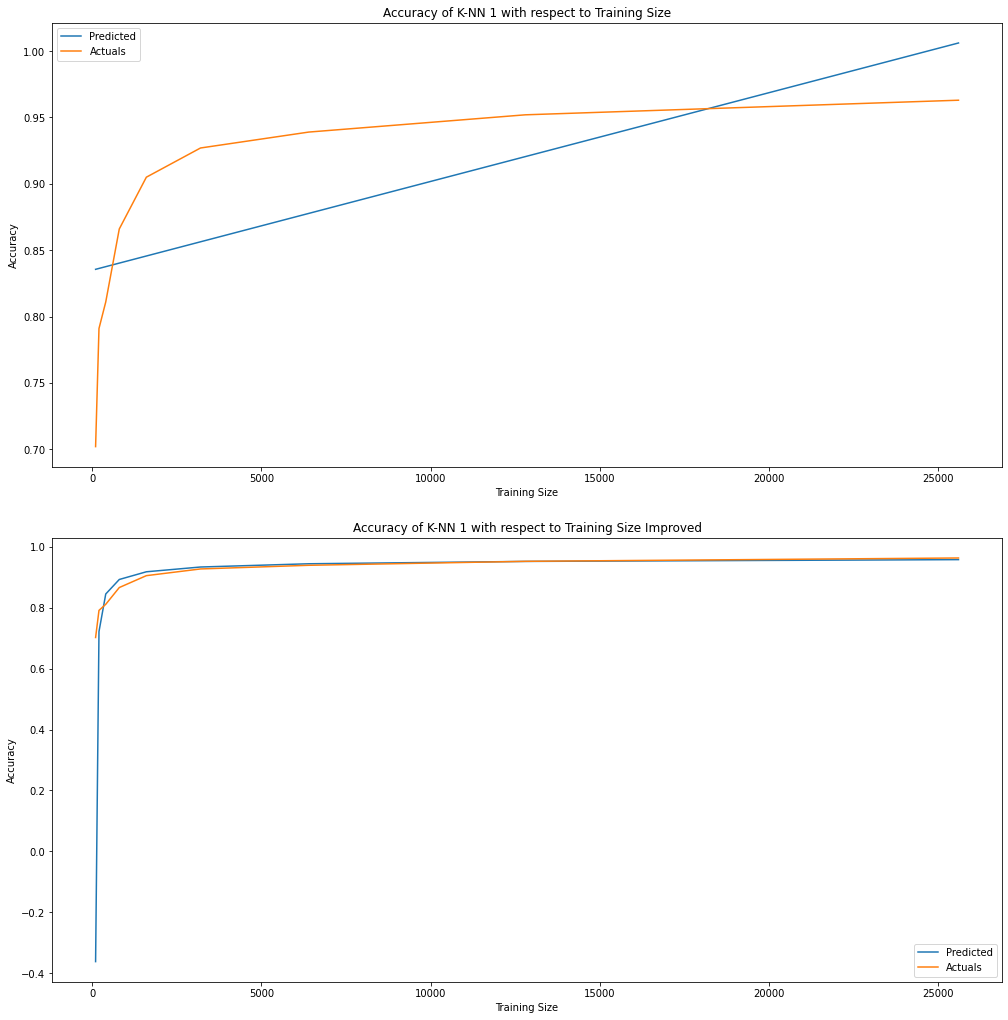

In [64]:
def Q4(train_size_data):

  # Creating 2 Subplots
  fig, axs = plt.subplots(2, figsize=(15, 15))
  # Added padding for proper visualizations
  fig.tight_layout(pad=5.0)

  # Translation functions from probability to ods and vicea versa
  probab_to_odds = lambda x: x/(1.0 - x)
  odds_to_probab = lambda x: x / (1.0 + x)

  # New training sizes that will be estimated later on
  new_training_size = [60000, 120000, 1000000]

  # Grabbing all training size and accuracy info from previous question and placing it in new lists
  training_sizes = [t_size['train_size'] for t_size in train_size_data]
  accuracies = [t_size['accuracy'] for t_size in train_size_data]

  # Creating a linear regression for training sizes and accuracies
  lr = LinearRegression()
  lr.fit(np.array(training_sizes).reshape(-1,1), accuracies)

  # Based on the parameters that were identified predicting accuracies
  predictions = lr.predict(np.array(training_sizes).reshape(-1,1))
  print(f"P1: = {predictions}\n")

  # R2 of the existing training sizes
  r2 = lr.score(np.array(training_sizes).reshape(-1,1), accuracies)
  print(f"R2 of the linear Regression 1: {r2}\n")

  # R2 of new training sizes
  predictions_with_extended_training = lr.predict(np.array(new_training_size).reshape(-1,1))
  print(f"Predctions for new training sizes {new_training_size} = {predictions_with_extended_training}")

  # Plotting the actuals vs. predictions of training size to accuracies
  axs[0].plot(training_sizes, predictions, label = "Predicted")
  axs[0].plot(training_sizes, accuracies, label = "Actuals" )
  axs[0].legend()
  axs[0].set_title('Accuracy of K-NN 1 with respect to Training Size')
  axs[0].set_xlabel('Training Size')
  axs[0].set_ylabel('Accuracy')

  # Transforming all trainig sizes to its log value 
  transformed_train_sizes = np.array(np.log(training_sizes)).reshape(-1,1)

  # Transforming all accuracies to log value
  transformed_accuracies = np.array(list(map(probab_to_odds, accuracies)))

  # Created new linear Regression
  lr2 = LinearRegression()
  # R2's of various combinations of regression parameters, decided that the params defined by both transformed axies showed to be closest to actuals
  #transformed train, transformed acc = 0.9395242859897991
  #reg train, transformed acc = 8649045423180002
  #transformed train, reg acc = 0.9068304252436641
  
  # Parameter identification with transformed datasets
  lr2.fit(transformed_train_sizes, transformed_accuracies)

  # Predicting accuracies from new regression params and transformed trainsizes
  predictions2 = lr2.predict(transformed_train_sizes)

  # R2 of newly transformed regressions
  r2_2 = lr2.score(transformed_train_sizes , transformed_accuracies)
  print(f"R2 of the linear Regression 2: {r2_2}\n")

  #Transformed log of extended training set
  transformed_train_sizes_extended = np.array(np.log(new_training_size)).reshape(-1,1)

  # New prediction with with new transformed data sizes
  predictions_with_extended_training_improved = lr2.predict(transformed_train_sizes_extended)

  # Plotting effectiveness of the KNN-1 with transformed datasets
  print(f"Improved Predctions for new training sizes {new_training_size} = {odds_to_probab(predictions_with_extended_training_improved)}\n")
  axs[1].plot(training_sizes, odds_to_probab(predictions2), label = "Predicted")
  axs[1].plot(training_sizes, accuracies, label = "Actuals" )
  axs[1].legend()
  axs[1].set_title('Accuracy of K-NN 1 with respect to Training Size Improved')
  axs[1].set_xlabel('Training Size')
  axs[1].set_ylabel('Accuracy')



Q4(train_size_eval)


**Answer to part 5:**

1) Our model is showing that accuracies will get to above 1 which is not possible since you cannot have an accuracy over 100% 2) The model currently does not fit our observed results.

### Question 5: Getting to know the confusion matrix.
---

1. Produce a 1-Nearest Neighbor model.
1. Show the confusion matrix. 
1. Which digit does the model most often confuse with which digit? (*for example, the model most often mistakes the digit $1$ as the digit $7$*).
1. Show examples of the misclassified digit.

Notes:
- Train on the mini train set.
- Evaluate performance on the dev set.
- You can use `confusion_matrix()` to produce a confusion matrix.
- No need to calculate the "most confused digits" programmatically.

Confusion Matrix for KNN - 1 on Development Data
[[101   0   1   0   0   2   1   0   1   0]
 [  0 116   4   2   0   0   2   1   5   1]
 [  1   1  84   0   1   0   1   1   4   0]
 [  0   0   2  84   0   1   0   0   3   0]
 [  0   0   2   0  78   1   1   0   1   3]
 [  0   0   0   6   0  77   2   0   3   2]
 [  1   0   2   0   0   5  94   0   0   0]
 [  1   0   4   2   2   0   0  96   1   7]
 [  2   1   6   3   0   2   1   0  72   0]
 [  0   0   1   0  11   0   0   4   4  82]]

The numbers: 4 and 9 are mistaken most for eachother.



4 Samples of mis-identified numbers of either 4 or 9


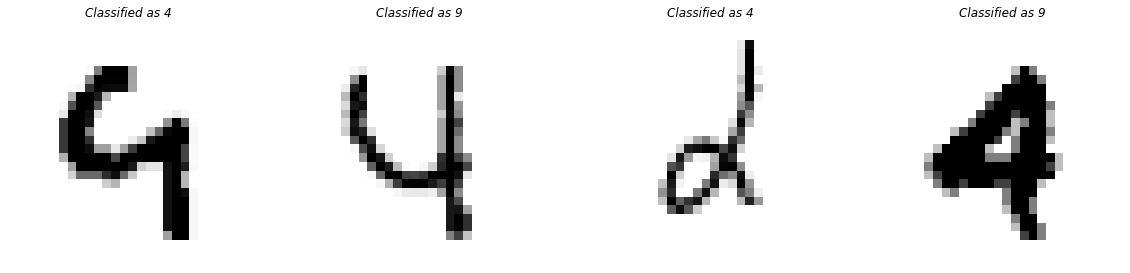

In [65]:
def Q5():
  # Number of of smples that I wanted to represent that were mis-identified
  NUM_OF_SAMPS = 4

  # K nearest neighbor of 1
  K_NEIGHBOR = 1

  # Counter Var
  c = 0

  fig, axs = plt.subplots(1, NUM_OF_SAMPS, figsize=(20,20))   

  # K nearest neighbor classifier for above neighbor number
  kNn_instance = KNeighborsClassifier(n_neighbors=K_NEIGHBOR)
  kNn_instance.fit(mini_train_data, mini_train_labels)

  # Based off of K value prediction of dev-data
  knn_predict_dev = kNn_instance.predict(dev_data)

  # Printing of KNN Confusion Matrix against dev data with respect to labels
  print(f"Confusion Matrix for KNN - 1 on Development Data")
  c_matrix = confusion_matrix(knn_predict_dev, dev_labels)
  m = 0

  # Var that holds the coordinates within the confusion matrix for highest sum
  coordinates = (0,0)
  print(c_matrix)

  # Algoritim for computing higest sum of misidentified numbers with respect to confusion matrix
  # Row iteratation
  for num in range(len(c_matrix)):

    # Collumn iterator
    for conf in range(len(c_matrix[num])):

      # Summing up current place within iteration loop & the numbers mirror accross the matrix
      sum = c_matrix[num][conf] + c_matrix[conf][num]

      # If the indicies match that is the correct classification of number to label so the algo doesnt need to account for these
      # if the sum of the mirroed confusions are greater than M add new sum to M and store the number is the coordinates value
      if num != conf and int(sum) > m:
        m = sum
        coordinates = (num,conf)

  print(f"\nThe numbers: {coordinates[0]} and {coordinates[1]} are mistaken most for eachother.")
  trans_dev_labels = np.array(dev_labels)
  
  print(f"\n\n\n{NUM_OF_SAMPS} Samples of mis-identified numbers of either {coordinates[0]} or {coordinates[1]}")

  # Iterate through dev data and compare predictions to lables if they do not match they are incorrectly classified and plotted
  for predNum in range(len(knn_predict_dev)):
    if int(knn_predict_dev[predNum]) == int(coordinates[0]) or int(knn_predict_dev[predNum]) == int(coordinates[1]):

      if int(trans_dev_labels[predNum]) != int(knn_predict_dev[predNum]):

        axs[c].imshow(dev_data.iloc[[predNum]].to_numpy().reshape(28,28), cmap=plt.cm.binary)
        axs[c].axis("off")
        axs[c].set_title(f"Classified as {knn_predict_dev[predNum]}", fontstyle='italic')
        c += 1
        if c == NUM_OF_SAMPS:
          break

Q5()



**Answer to Part 3**

Tthe most mis-identified digits from eachother are 4 and 9. It was determied with the above algorithim